In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ----------------------------
# 1. Grid setup
# ----------------------------
nx, ny, nz = 64, 64, 64           # number of cells
dx, dy, dz = 100.0, 100.0, 100.0  # grid spacing in meters
Lx, Ly, Lz = nx * dx, ny * dy, nz * dz

x = np.linspace(0, Lx, nx, endpoint=False)
y = np.linspace(0, Ly, ny, endpoint=False)
z = np.linspace(0, Lz, nz, endpoint=False)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# ----------------------------
# 2. Physical constants
# ----------------------------
g   = 9.81           # gravity (m/s^2)
cp  = 1004.0         # specific heat of air (J/kg/K)
Lv  = 2.5e6          # latent heat of vaporization (J/kg)
theta0_surf = 300.0  # surface potential temperature (K)
Gamma = 3.0 / 1000.0 # background gradient (K/m)
qv0_surf = 0.012     # surface water vapor mixing ratio (kg/kg)
rho0 = 1.0           # reference density (Boussinesq constant)
nu = 10.0            # kinematic viscosity (m^2/s)
kappa = 10.0         # thermal diffusivity (m^2/s)
Dq = 10.0            # moisture diffusivity (m^2/s)

# ----------------------------
# 3. Time setup
# ----------------------------
dt = 0.5    # seconds
t = 0.0
t_end = 600.0  # total time in seconds (10 minutes)

# ----------------------------
# 4. Background profiles
# ----------------------------
theta_bg = theta0_surf + Gamma * Z
qv_bg = qv0_surf * np.exp(-Z / 2000.0)  # exponential decay with height

# ----------------------------
# 5. State variables
# ----------------------------
u = np.zeros((nx, ny, nz))
v = np.zeros((nx, ny, nz))
w = np.zeros((nx, ny, nz))

theta_prime = np.zeros((nx, ny, nz))  # perturbation potential temperature
qv = qv_bg.copy()                     # water vapor
qc = np.zeros((nx, ny, nz))           # cloud water
pi_prime = np.zeros((nx, ny, nz))     # pressure perturbation

# ----------------------------
# 6. Initial thermal bubble
# ----------------------------
bubble_center = (Lx/2, Ly/2, 300.0)
bubble_radius = 500.0
dtheta = 1.5  # K
dqv = 0.0015  # kg/kg

r2 = (X - bubble_center[0])**2 + (Y - bubble_center[1])**2 + (Z - bubble_center[2])**2
mask = r2 < bubble_radius**2
theta_prime[mask] += dtheta * np.exp(-r2[mask] / bubble_radius**2)
qv[mask] += dqv * np.exp(-r2[mask] / bubble_radius**2)

print("Initialized 3D moist Boussinesq domain.")
print(f"Domain: {Lx/1000:.1f} x {Ly/1000:.1f} x {Lz/1000:.1f} km")
print(f"Grid: {nx} x {ny} x {nz}, Δ = {dx:.0f} m")


Initialized 3D moist Boussinesq domain.
Domain: 6.4 x 6.4 x 6.4 km
Grid: 64 x 64 x 64, Δ = 100 m


In [3]:
def _zeros_like_state(state):
    """Return a dict of zero arrays matching the prognostic fields' shapes."""
    return {
        'u': np.zeros_like(state['u']),
        'v': np.zeros_like(state['v']),
        'w': np.zeros_like(state['w']),
        'theta_p': np.zeros_like(state['theta_p']),
        'qv': np.zeros_like(state['qv']),
        'qc': np.zeros_like(state['qc']),
    }


def _copy_state(state):
    """Deep copy of the prognostic fields + pi."""
    return {
        'u': state['u'].copy(),
        'v': state['v'].copy(),
        'w': state['w'].copy(),
        'theta_p': state['theta_p'].copy(),
        'qv': state['qv'].copy(),
        'qc': state['qc'].copy(),
        'pi': state.get('pi', np.zeros_like(state['u'])).copy()
    }


In [4]:
# 2nd-order upwind advection for scalars and velocity + wiring into compute_rhs + tests.
# Periodic boundaries in all directions. Returns RHS tendencies (no time integration inside).
#
# What this does:
#   Advection computes the conservative form:  ∂φ/∂t = -∇·(φ U)
#   We build face fluxes Fx,Fy,Fz using a 2nd-order upwind interpolation of φ to faces,
#   with face velocities from centered averages. Then take the flux divergence.
#
# Note:
#   - This is a pure RHS operator. You still use RK2 (or any scheme) outside to advance in time.
#   - Periodic in x,y,z via np.roll.
#
import numpy as np

def _face_average(a, axis):
    """Centered average to faces along 'axis' with periodic wrap: a_{i+1/2} = 0.5*(a_i + a_{i+1})."""
    return 0.5 * (a + np.roll(a, -1, axis=axis))

def _upwind2_to_faces(phi, vel_faces, axis):
    """
    2nd-order upwind interpolation of phi to faces along 'axis', using periodic BCs.
    For each face, choose the upwind-biased stencil based on sign of face velocity.
      If u_face > 0:  phi_{i+1/2} ≈ (3/2) phi_i   - (1/2) phi_{i-1}
      If u_face < 0:  phi_{i+1/2} ≈ (3/2) phi_{i+1} - (1/2) phi_{i+2}
    """
    phi_i   = phi
    phi_im1 = np.roll(phi,  1, axis=axis)
    phi_ip1 = np.roll(phi, -1, axis=axis)
    phi_ip2 = np.roll(phi, -2, axis=axis)

    # candidate reconstructions
    phi_face_pos = 1.5*phi_i   - 0.5*phi_im1
    phi_face_neg = 1.5*phi_ip1 - 0.5*phi_ip2

    # select by velocity sign
    return np.where(vel_faces > 0.0, phi_face_pos, phi_face_neg)

def advect_scalar(phi, u, v, w, dx, dy, dz):
    """
    2nd-order upwind scalar advection RHS: dphi/dt = -∇·(phi U).
    Inputs:
      phi: scalar field (nx,ny,nz)
      u,v,w: velocity components at cell centers (nx,ny,nz)
      dx,dy,dz: grid spacings
    Output:
      rhs (same shape): advection tendency
    """
    # Face velocities (centered average to faces)
    ux = _face_average(u, axis=0)  # shape (nx,ny,nz), interpreted at i+1/2 faces
    vy = _face_average(v, axis=1)  # j+1/2
    wz = _face_average(w, axis=2)  # k+1/2

    # Upwind 2nd-order scalar to faces
    phi_xf = _upwind2_to_faces(phi, ux, axis=0)
    phi_yf = _upwind2_to_faces(phi, vy, axis=1)
    phi_zf = _upwind2_to_faces(phi, wz, axis=2)

    # Fluxes at faces
    Fx = ux * phi_xf
    Fy = vy * phi_yf
    Fz = wz * phi_zf

    # Divergence of flux (periodic): (F_{i+1/2}-F_{i-1/2})/dx, etc.
    dFx = (np.roll(Fx, -1, axis=0) - Fx) / dx
    dFy = (np.roll(Fy, -1, axis=1) - Fy) / dy
    dFz = (np.roll(Fz, -1, axis=2) - Fz) / dz

    rhs = -(dFx + dFy + dFz)
    return rhs

def advect_velocity(u, v, w, dx, dy, dz):
    """
    2nd-order upwind advection for velocity components (component-wise passive advection):
      du/dt = -∇·(u U),  dv/dt = -∇·(v U),  dw/dt = -∇·(w U),
    where U=(u,v,w) is the advecting velocity field.
    Returns three RHS arrays.
    """
    rhs_u = advect_scalar(u, u, v, w, dx, dy, dz)
    rhs_v = advect_scalar(v, u, v, w, dx, dy, dz)
    rhs_w = advect_scalar(w, u, v, w, dx, dy, dz)
    return rhs_u, rhs_v, rhs_w

In [5]:
# -----------------
# Laplacian (periodic) and diffusion operators
# -----------------
def laplacian_periodic(phi, dx, dy, dz):
    """
    3D Laplacian with periodic boundaries in all directions.
    Centered 2nd-order finite differences.
    """
    # roll implements periodic neighbors
    d2x = (np.roll(phi, -1, axis=0) - 2.0*phi + np.roll(phi,  1, axis=0)) / (dx*dx)
    d2y = (np.roll(phi, -1, axis=1) - 2.0*phi + np.roll(phi,  1, axis=1)) / (dy*dy)
    d2z = (np.roll(phi, -1, axis=2) - 2.0*phi + np.roll(phi,  1, axis=2)) / (dz*dz)
    return d2x + d2y + d2z

def diffuse_scalar(phi, kappa, dx, dy, dz):
    """
    Return diffusion tendency for a scalar field: dphi/dt = kappa * Laplacian(phi).
    """
    if kappa == 0.0:
        return np.zeros_like(phi)
    return kappa * laplacian_periodic(phi, dx, dy, dz)

def diffuse_velocity(u, v, w, nu, dx, dy, dz):
    """
    Return diffusion tendencies for velocity components: du/dt = nu * Laplacian(u), etc.
    """
    if nu == 0.0:
        z = np.zeros_like(u)
        return z, z.copy(), z.copy()
    Lu = laplacian_periodic(u, dx, dy, dz)
    Lv = laplacian_periodic(v, dx, dy, dz)
    Lw = laplacian_periodic(w, dx, dy, dz)
    return nu * Lu, nu * Lv, nu * Lw

In [6]:
def compute_buoyancy(theta_p, qv, qv_bg, qc, theta0, g=9.81):
    """
    Buoyancy for moist Boussinesq:
      b = g * ( theta'/theta0 + 0.61*qv - qc )
    Inputs:
      theta_p: potential temperature perturbation θ' (K)
      qv: water vapor mixing ratio (kg/kg)
      qc: cloud liquid water mixing ratio (kg/kg)
      theta0: background potential temperature θ0(z) or 3D broadcast (K)
      g: gravity (m/s^2)
    Output:
      b: buoyancy (m/s^2), same shape
    """
    qv_prime = qv - qv_bg
    return g * ( (theta_p / theta0) + 0.61*qv_prime - qc )

def theta_rhs_extra(w, dtheta0_dz):
    """
    Background cooling/heating due to motion through stratification:
      ∂θ'/∂t |_bg = - w * dθ0/dz
    Inputs:
      w: vertical velocity (m/s)
      dtheta0_dz: vertical gradient of background θ0 (K/m)
    Output:
      rhs_theta_extra: same shape

      how temperature change is handled relative to altitude/vertical velocity. as you rise it gets cooler, this is what handles this
    """
    return - w * dtheta0_dz

# ---- Wiring helper: how to add into compute_rhs ----
def add_buoyancy_and_theta_to_rhs(state, params, rhs):
    """
    Mutates rhs in-place to include:
      - w-tendency from buoyancy (+b)
      - theta' tendency from background cooling (-w dθ0/dz)
    Expects in params:
      theta0 : 3D array (or broadcastable) of θ0
      dtheta0_dz : 3D array (or broadcastable) of dθ0/dz
      g : gravity (optional)
    """
    g = params.get('g', 9.81)
    theta0 = params['theta0']
    dthdz  = params['dtheta0_dz']

    b = compute_buoyancy(state['theta_p'], state['qv'], params['qv_bg'], state['qc'], theta0, g=g)
    rhs['w']       += b
    rhs['theta_p'] += theta_rhs_extra(state['w'], dthdz)

In [7]:
# --- Thermo helpers ---
def exner(p, p_ref=1.0e5, R=287.0, cp=1004.0):
    """Exner function Π = (p/p_ref)^(R/cp)."""
    return (p / p_ref) ** (R / cp)

def saturation_vapor_pressure_water(T):
    """
    Saturation vapor pressure over liquid water (Pa).
    Using Bolton (1980)-style Magnus formula:
      es(hPa) = 6.112 * exp(17.67*(T-273.15)/(T-29.65))
    Convert to Pa by *100.
    """
    Tc = T - 273.15
    es_hPa = 6.112 * np.exp(17.67 * Tc / (Tc + 243.5))  # using 243.5 vs 29.65 in denominator (common variant)
    return es_hPa * 100.0

def saturation_mixing_ratio(T, p, epsilon=0.622):
    """
    Saturation mixing ratio q_s(T,p) = epsilon * es / (p - es), kg/kg.
    T in K, p in Pa.
    """
    es = saturation_vapor_pressure_water(T)
    es = np.minimum(es, 0.99 * p)  # safety clamp to avoid division blow-up
    return epsilon * es / (p - es)

# --- Microphysics: saturation adjustment
def microphysics_saturation_adjust(theta_p, qv, qc, theta0, p0,
                                   Lv=2.5e6, cp=1004.0, R=287.0, p_ref=1.0e5,
                                   eps=0.622, tol=1e-12):
    """
    In-place saturation adjustment at each cell:
      If qv > qs: condense Δ=qv-qs -> qv-=Δ, qc+=Δ, theta_p += (Lv/(cp*Pi))*Δ
      If qv < qs and qc>0: evaporate Δ=min(qs-qv, qc) -> qv+=Δ, qc-=Δ, theta_p -= (Lv/(cp*Pi))*Δ
    Inputs may be scalars or numpy arrays (broadcastable to a common shape).
    All arrays are modified in place.
    """
    # Compute Exner and T from (theta0 + theta_p)
    Pi = exner(p0, p_ref=p_ref, R=R, cp=cp)
    theta = theta0 + theta_p
    T = theta * Pi

    qs = saturation_mixing_ratio(T, p0, epsilon=eps)

    # Supersaturation mask -> condensation
    d_cond = np.where(qv > qs + tol, qv - qs, 0.0)
    qv = np.subtract(qv, d_cond)
    qc = np.add(qc, d_cond)
    theta_p = np.add(theta_p, (Lv / (cp * Pi)) * d_cond)

    # Sub-saturation + available cloud water -> evaporation
    # Recompute T and qs after possible condensation? For instant adjustment we can reuse qs;
    # the latent update slightly changes T, but to keep it simple & consistent with "single step",
    # we can allow one pass. A second pass would refine toward exact saturation.
    need = np.maximum(qs - qv - tol, 0.0)            # how much vapor is needed to reach qs
    d_evap = np.minimum(need, qc)                    # can only evaporate what exists
    qv = np.add(qv, d_evap)
    qc = np.subtract(qc, d_evap)
    theta_p = np.subtract(theta_p, (Lv / (cp * Pi)) * d_evap)

    # clip tiny negatives
    qv = np.maximum(qv, 0.0)
    qc = np.maximum(qc, 0.0)

    return theta_p, qv, qc

In [8]:
def _wavenumbers(n, d):
    """
    Angular wavenumbers for periodic FFT derivatives.
    k = 2π * fftfreq(n, d)
    """
    return 2.0 * np.pi * np.fft.fftfreq(n, d=d)

def project_velocity(u, v, w, dx, dy, dz):
    """
    Periodic FFT-based projection.
    Inputs:
      u,v,w : 3D arrays of provisional velocity (cell-centered)
      dx,dy,dz : grid spacings
    Returns:
      u_corr, v_corr, w_corr, psi  (all real-valued 3D arrays)
    """
    # FFTs of components
    U = np.fft.fftn(u)
    V = np.fft.fftn(v)
    W = np.fft.fftn(w)

    nx, ny, nz = u.shape
    kx = _wavenumbers(nx, dx)[:, None, None]
    ky = _wavenumbers(ny, dy)[None, :, None]
    kz = _wavenumbers(nz, dz)[None, None, :]

    # Divergence in spectral space: div_k = i(kx U + ky V + kz W)
    i = 1j
    div_k = i*(kx*U + ky*V + kz*W)

    # Solve Laplace: ∇²ψ = div  =>  -k^2 ψ_k = div_k  => ψ_k = -div_k / k^2
    k2 = kx**2 + ky**2 + kz**2
    psi_k = np.zeros_like(U, dtype=complex)
    mask = k2 != 0.0
    psi_k[mask] = -div_k[mask] / k2[mask]
    psi_k[~mask] = 0.0  # zero-mean gauge

    # Gradient of psi in spectral space
    Gx_k = i * kx * psi_k
    Gy_k = i * ky * psi_k
    Gz_k = i * kz * psi_k

    # Corrected velocities
    Uc = U - Gx_k
    Vc = V - Gy_k
    Wc = W - Gz_k

    u_corr = np.fft.ifftn(Uc).real
    v_corr = np.fft.ifftn(Vc).real
    w_corr = np.fft.ifftn(Wc).real
    psi    = np.fft.ifftn(psi_k).real

    return u_corr, v_corr, w_corr, psi

In [30]:
# Minimal RK2 scaffold for your first step.
# - compute_rhs: returns zero tendencies (stub)
# - project_velocity: identity (no-op)
# - step_rk2: orchestrates RK2 calls following the choreography
#
# Includes a tiny smoke test to confirm that with zero RHS and identity projection,
# the state remains unchanged after one step.


def advect_scalar(phi, u, v, w, dx, dy, dz):
    """
    First-order upwind scalar advection:
      dphi/dt = -∇·(phi U)
    Periodic in all directions. Monotone and robust for debugging.
    """
    # x-direction faces
    ux = 0.5 * (u + np.roll(u, -1, axis=0))
    phi_L = phi
    phi_R = np.roll(phi, -1, axis=0)
    phi_xf = np.where(ux > 0.0, phi_L, phi_R)
    Fx = ux * phi_xf

    # y-direction faces
    vy = 0.5 * (v + np.roll(v, -1, axis=1))
    phi_L = phi
    phi_R = np.roll(phi, -1, axis=1)
    phi_yf = np.where(vy > 0.0, phi_L, phi_R)
    Fy = vy * phi_yf

    # z-direction faces
    wz = 0.5 * (w + np.roll(w, -1, axis=2))
    phi_L = phi
    phi_R = np.roll(phi, -1, axis=2)
    phi_zf = np.where(wz > 0.0, phi_L, phi_R)
    Fz = wz * phi_zf

    dFx = (np.roll(Fx, -1, axis=0) - Fx) / dx
    dFy = (np.roll(Fy, -1, axis=1) - Fy) / dy
    dFz = (np.roll(Fz, -1, axis=2) - Fz) / dz

    return -(dFx + dFy + dFz)

def advect_velocity(u, v, w, dx, dy, dz):
    """
    Advect each velocity component with U = (u,v,w).
    Uses the same robust first-order upwind scheme.
    """
    rhs_u = advect_scalar(u, u, v, w, dx, dy, dz)
    rhs_v = advect_scalar(v, u, v, w, dx, dy, dz)
    rhs_w = advect_scalar(w, u, v, w, dx, dy, dz)
    return rhs_u, rhs_v, rhs_w

# -----------------
# Stubs / placeholders
# -----------------
def compute_rhs(state, params=None):
    """
    Stub RHS builder.
    Returns tendencies for prognostic fields as zeros (same shapes).
    Expand later with advection, diffusion, buoyancy, etc.
    """
    rhs = _zeros_like_state(state)
    dx, dy, dz = params['dx'], params['dy'], params['dz']

    add_buoyancy_and_theta_to_rhs(state, params, rhs)
    # # after buoyancy, bound w
    tau = params.get('tau_damp_w', 300.0)   # seconds
    rhs['w'] += -(state['w'] / tau)


    # # advection
    du_adv, dv_adv, dw_adv = advect_velocity(state['u'], state['v'], state['w'], dx, dy, dz)
    rhs['u'] += du_adv
    rhs['v'] += dv_adv
    rhs['w'] += dw_adv

    rhs['theta_p'] += advect_scalar(state['theta_p'], state['u'], state['v'], state['w'], dx, dy, dz)
    rhs['qv']      += advect_scalar(state['qv'],      state['u'], state['v'], state['w'], dx, dy, dz)
    rhs['qc']      += advect_scalar(state['qc'],      state['u'], state['v'], state['w'], dx, dy, dz)


    # # diffusion
    nu = params.get('nu', 0.0)
    kappa = params.get('kappa', 0.0)
    Dq = params.get('Dq', 0.0)

    du, dv, dw = diffuse_velocity(state['u'], state['v'], state['w'], nu, dx, dy, dz)
    rhs['u'] += du
    rhs['v'] += dv
    rhs['w'] += dw

    rhs['theta_p'] += diffuse_scalar(state['theta_p'], kappa, dx, dy, dz)
    rhs['qv']      += diffuse_scalar(state['qv'],      Dq,    dx, dy, dz)
    rhs['qc']      += diffuse_scalar(state['qc'],      Dq,    dx, dy, dz)

    return rhs

# def compute_rhs(state, params=None):
#     rhs = _zeros_like_state(state)
#     dx, dy, dz = params['dx'], params['dy'], params['dz']

#     theta0 = params['theta0']
#     g = params.get('g', 9.81)
#     qv0 = params.get('qv0', np.zeros_like(theta0))

#     # diagnostics from conserved vars
#     theta, theta_p, qv = diagnose_thermo(state, params)
#     qc = state['qc']
#     theta_p = state.get('theta_p', np.zeros_like(theta0))

#     # --- Buoyancy: use moist anomalies, not absolute qv ---
#     # b = g * ( θ'/θ0 + 0.61 (qv - qv0) - qc )
#     # b = g * (theta_p / theta0 + 0.61 * (qv - qv0) - qc)
#     # b = g * (theta_p / theta0)
#     # rhs['w'] += b
#     add_buoyancy_and_theta_to_rhs(state, params, rhs)

#     # # Rayleigh damping
#     tau = params.get('tau_damp_w', 300.0)
#     rhs['w'] += -(state['w'] / tau)

#     # Advection on u,v,w and conserved scalars
#     # du_adv, dv_adv, dw_adv = advect_velocity(state['u'], state['v'], state['w'], dx, dy, dz)
#     # rhs['u'] += du_adv
#     # rhs['v'] += dv_adv
#     # rhs['w'] += dw_adv

#     rhs['theta_l'] += advect_scalar(state['theta_l'], state['u'], state['v'], state['w'], dx, dy, dz)
#     rhs['qt']      += advect_scalar(state['qt'],      state['u'], state['v'], state['w'], dx, dy, dz)
#     rhs['qc']      += advect_scalar(state['qc'],      state['u'], state['v'], state['w'], dx, dy, dz)

#     # Diffusion (keep modest but nonzero)
#     nu    = params.get('nu', 0.0)
#     kappa = params.get('kappa', 0.0)
#     Dq    = params.get('Dq', 0.0)

#     du, dv, dw = diffuse_velocity(state['u'], state['v'], state['w'], nu, dx, dy, dz)
#     rhs['u'] += du
#     rhs['v'] += dv
#     rhs['w'] += dw

#     rhs['theta_l'] += diffuse_scalar(state['theta_l'], kappa, dx, dy, dz)
#     rhs['qt']      += diffuse_scalar(state['qt'],      Dq,    dx, dy, dz)
#     rhs['qc']      += diffuse_scalar(state['qc'],      Dq,    dx, dy, dz)

#     return rhs



def apply_bcs(state, params=None):
    """Boundary conditions placeholder (no-op for now)."""
    return state

# -----------------
# RK2 stepper
# -----------------
def step_rk2(state, dt, params=None):
    """
    RK2 / Heun orchestrator using the stubbed pieces.
    Order:
      1) BCs
      2) rhs1
      3) provisional state*
      4) microphysics(state*)
      5) BCs(state*)
      6) projection (identity for now)
      7) rhs2 at state*
      8) final combine
      9) microphysics(final)
      10) BCs(final)
    """
    s0 = _copy_state(state)
    apply_bcs(s0, params)

    # # Stage 1 RHS
    rhs1 = compute_rhs(s0, params)

    # # Provisional state*
    s_star = _copy_state(s0)
    s_star['u']       = s0['u']       + dt * rhs1['u']
    s_star['v']       = s0['v']       + dt * rhs1['v']
    s_star['w']       = s0['w']       + dt * rhs1['w']
    s_star['theta_p'] = s0['theta_p'] + dt * rhs1['theta_p']
    s_star['qv']      = s0['qv']      + dt * rhs1['qv']
    s_star['qc']      = s0['qc']      + dt * rhs1['qc']

    # Microphysics + BCs
    s_star['theta_p'], s_star['qv'], s_star['qc'] = microphysics_saturation_adjust(s_star['theta_p'], s_star['qv'], s_star['qc'], params['theta0'], params['p0'])
    apply_bcs(s_star, params)

    # Projection (identity)
    s_star['u'], s_star['v'], s_star['w'], s_star['pi'] = project_velocity(
        s_star['u'], s_star['v'], s_star['w'], dx, dy, dz
    )

    # Stage 2 RHS
    rhs2 = compute_rhs(s_star, params)

    # Final combine
    s_new = _copy_state(s0)
    s_new['u']       = s0['u']       + 0.5 * dt * (rhs1['u']       + rhs2['u'])
    s_new['v']       = s0['v']       + 0.5 * dt * (rhs1['v']       + rhs2['v'])
    s_new['w']       = s0['w']       + 0.5 * dt * (rhs1['w']       + rhs2['w'])
    s_new['theta_p'] = s0['theta_p'] + 0.5 * dt * (rhs1['theta_p'] + rhs2['theta_p'])
    s_new['qv']      = s0['qv']      + 0.5 * dt * (rhs1['qv']      + rhs2['qv'])
    s_new['qc']      = s0['qc']      + 0.5 * dt * (rhs1['qc']      + rhs2['qc'])

    # Final microphysics + BCs
    s_new['theta_p'], s_new['qv'], s_new['qc'] = microphysics_saturation_adjust(s_new['theta_p'], s_new['qv'], s_new['qc'], params['theta0'], params['p0'])
    apply_bcs(s_new, params)

    # Projection (identity)
    s_new['u'], s_new['v'], s_new['w'], s_new['pi'] = project_velocity(
        s_new['u'], s_new['v'], s_new['w'], dx, dy, dz
    )


    return s_new
# def step_rk2(state, dt, params=None):
#     params = params or {}
#     dx, dy, dz = params['dx'], params['dy'], params['dz']

#     s0 = _copy_state(state)
#     apply_bcs(s0, params)

#     # Stage 1
#     rhs1 = compute_rhs(s0, params)

#     s_star = _copy_state(s0)
#     for k in ('u', 'v', 'w', 'theta_l', 'qt', 'qc'):
#         s_star[k] = s0[k] + dt * rhs1[k]

#     apply_bcs(s_star, params)
#     # microphysics_saturation_adjust_state(s_star, params)

#     # Projection
#     # s_star['u'], s_star['v'], s_star['w'], s_star['pi'] = project_velocity(
#     #     s_star['u'], s_star['v'], s_star['w'], dx, dy, dz
#     # )

#     # Stage 2
#     rhs2 = compute_rhs(s_star, params)

#     s_new = _copy_state(s0)
#     for k in ('u', 'v', 'w', 'theta_l', 'qt', 'qc'):
#         s_new[k] = s0[k] + 0.5 * dt * (rhs1[k] + rhs2[k])

#     apply_bcs(s_new, params)
#     # microphysics_saturation_adjust_state(s_new, params)

#     return s_new



max(qv - qs) at t=0: -0.00208201933128921
Running... (expect qc to flip on near the bubble as it lifts, w to grow)
mean w: 0.0005173105519176698
step    0: max qc = 0.000 g/kg | max w = 0.011 m/s | max θ' = 0.491 K


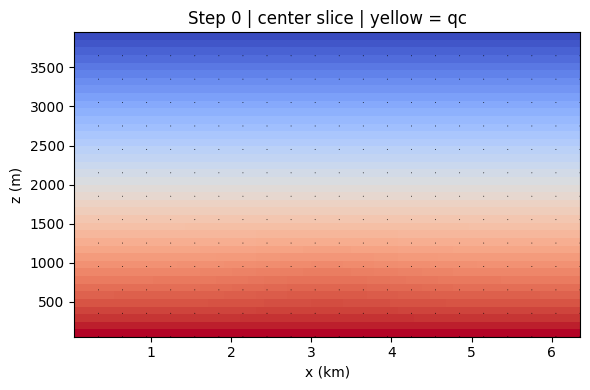

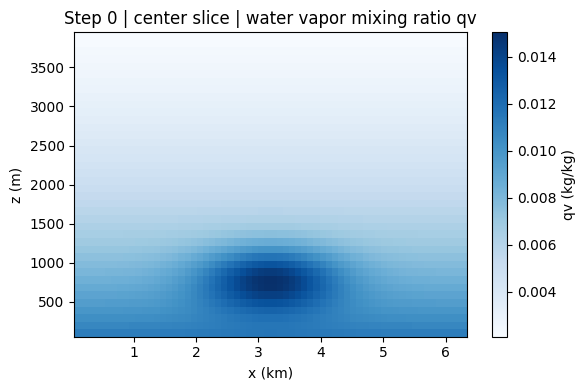

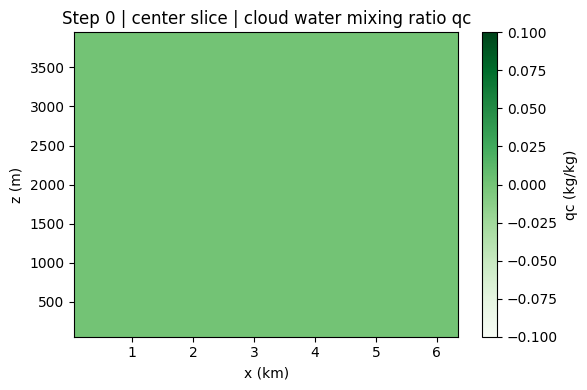

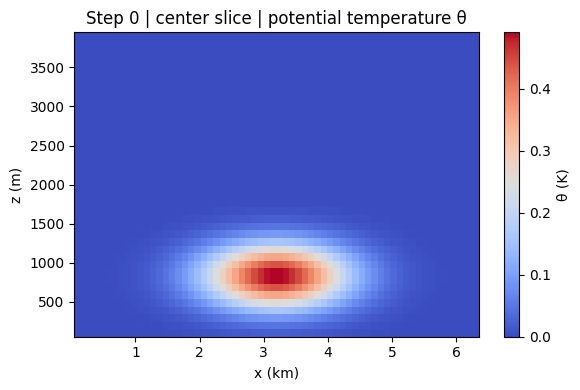

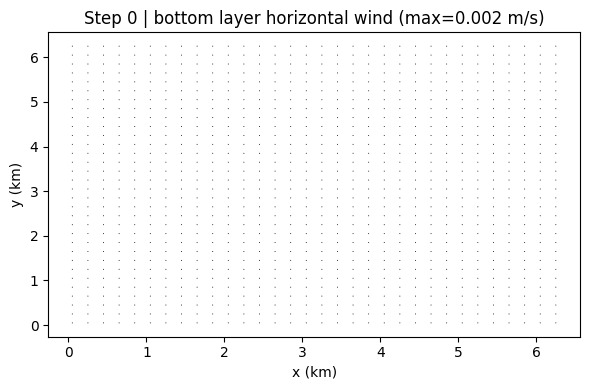

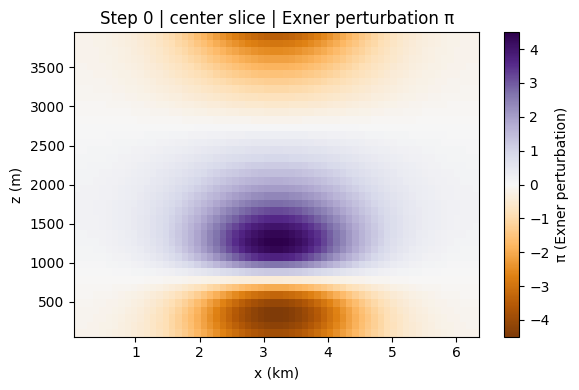

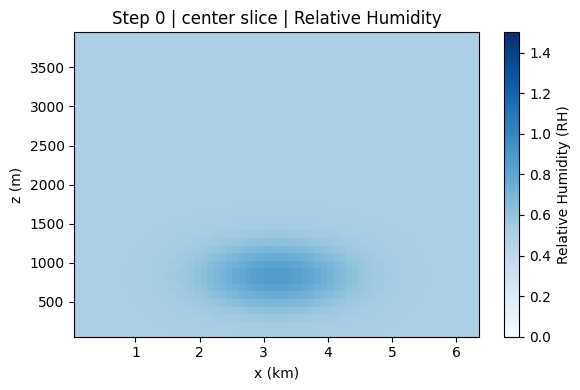

mean w: 0.001033788397387477
mean w: 0.0015494636117595268
mean w: 0.0020643661757205095
mean w: 0.002578525977116615
mean w: 0.0030919728127682586
mean w: 0.0036047363902767305
mean w: 0.004116846329822876
mean w: 0.004628332165957944
mean w: 0.00513922334938668


In [ ]:
# ------------------ Initialization that makes a small cloud ------------------
nx, ny, nz = 64, 64, 40
Lx, Ly, Lz = 6400.0, 6400.0, 4000.0   # 6.4 km × 6.4 km × 4 km
dx, dy, dz = Lx/nx, Ly/ny, Lz/nz

# Grid
x = (np.arange(nx)+0.5)*dx
y = (np.arange(ny)+0.5)*dy
z = (np.arange(nz)+0.5)*dz
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# --- Background thermodynamics ---
theta0_surface = 300.0  # K
dtheta0_dz = -0.0065    # K/m  (temperature decreases upward)
theta0 = theta0_surface + dtheta0_dz * Z
T0 = theta0.copy()      # treat as actual temperature here

p0 = 1.0e5  # Pa

# Saturation mixing ratio (same form as your microphysics)
def qsat(T, p, eps=0.622):
    es = 610.94 * np.exp(17.625*(T - 273.15)/(T - 30.11))  # Pa
    return eps * es / (p - es)

qs_bg = qsat(T0, p0)

# Background relative humidity (~80%)
RH_bg = 0.5
qv_bg = RH_bg * qs_bg

# # --- Warm, moist bubble (radius ~800 m) centered near 400 m height ---
# xb, yb, zb = Lx*0.5, Ly*0.5, 400.0
# rb = 800.0
# r2 = (X - xb)**2 + (Y - yb)**2 + (Z - zb)**2
# bubble = np.exp(-r2 / (2.0 * rb**2))

# # Bubble is slightly warmer and closer to saturation
# RH_bubble = 0.9
# theta_p0 = 0.5 * bubble          # ~+0.5 K warm anomaly
# qv0 = qv_bg + (RH_bubble * qs_bg - qv_bg) * bubble
# --- Warm, moist bubble centered near 800 m, vertically compact ---
xb, yb, zb = Lx*0.5, Ly*0.5, 800.0

rb_xy = 800.0   # horizontal radius
rb_z  = 300.0   # vertical radius (tighter)

r2_xy = (X - xb)**2 + (Y - yb)**2
r2_z  = (Z - zb)**2

bubble = np.exp(-r2_xy / (2.0 * rb_xy**2) - r2_z / (2.0 * rb_z**2))


RH_bubble = 0.9
theta_p0 = 0.5 * bubble
qv0 = qv_bg + (RH_bubble * qs_bg - qv_bg) * bubble

# --- Zero initial motion, no cloud water ---
u0 = np.zeros_like(theta0)
v0 = np.zeros_like(theta0)
w0 = np.zeros_like(theta0)
qc0 = np.zeros_like(theta0)
pi0 = np.zeros_like(theta0)

state = {
    'u': u0, 'v': v0, 'w': w0,
    'theta_p': theta_p0,
    'qv': qv0, 'qc': qc0, 'pi': pi0
}

params = {
    'dx': dx, 'dy': dy, 'dz': dz,
    'theta0': theta0,
    'dtheta0_dz': np.full_like(theta0, dtheta0_dz),
    'p0': p0,
    'Lv': 2.5e6, 'cp': 1004.0, 'R': 287.0,
    'p_ref': 1.0e5, 'eps': 0.622,
    'g': 9.81,
    'qv_bg': qv_bg,
}

# --- quick diagnostic to verify no initial supersaturation ---
T_init = T0 + theta_p0
qs_init = qsat(T_init, p0)
print("max(qv - qs) at t=0:", np.max(qv0 - qs_init))


# --- run a short integration: buoyancy + microphysics only ---
dt = 0.01  # seconds (tiny, safe)
steps = 200

def diag(state, step):
    qc_max = state['qc'].max()
    w_max  = state['w'].max()
    thp_max= state['theta_p'].max()
    print(f"step {step:4d}: max qc = {qc_max*1000:.3f} g/kg | max w = {w_max:.3f} m/s | max θ' = {thp_max:.3f} K")

print("Running... (expect qc to flip on near the bubble as it lifts, w to grow)")
plt.figure()
for n in range(steps):
    dt = compute_dt(state, params, cfl=0.4)
    state = step_rk2(state, dt, params)
    print("mean w:", state['w'].mean())

    if n % 10 == 0 or n == steps-1:
        diag(state, n)
        plot_state(state, n, params)
        plot_qv(state, n, params)
        plot_qc(state, n, params)
        plot_theta_p(state, n, params)
        plot_bottom_wind(state, n, params)
        plot_pi(state, n, params)
        plot_relative_humidity(state, n, params)

# Provide simple summaries for quick confirmation
qc_any = float((state['qc']>0).sum())
wpos = float((state['w']>0).sum())
print("\nSummary: cells with cloud water >", qc_any, " | cells with upward motion >", wpos)


In [34]:
def plot_state(state, step, params):
    u = state['u']; w = state['w']
    qc = state['qc']
    theta_p = state['theta_p']  # kept in sync
    theta0 = params['theta0']

    nx, ny, nz = u.shape
    j = ny // 2
    dx, dz = params['dx'], params['dz']

    x = (np.arange(nx) + 0.5)*dx / 1000.0
    z = (np.arange(nz) + 0.5)*dz

    T_slice = (theta0 + theta_p)[:, j, :]
    u_slice = u[:, j, :]
    w_slice = w[:, j, :]
    qc_slice = qc[:, j, :]

    cmap = plt.cm.coolwarm
    norm = plt.Normalize(vmin=T_slice.min(), vmax=T_slice.max())
    rgba = cmap(norm(T_slice))

    cloud_mask = qc_slice > 1e-4
    rgba[cloud_mask] = (1.0, 1.0, 0.0, 1.0)

    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(6, 4)
    extent = [x.min(), x.max(), z.min(), z.max()]
    plt.imshow(rgba.transpose(1,0,2), origin='lower', aspect='auto', extent=extent)

    skip = 3
    Xq, Zq = np.meshgrid(x[::skip], z[::skip], indexing='ij')
    Uq = u_slice[::skip, ::skip]
    Wq = w_slice[::skip, ::skip]
    plt.quiver(Xq, Zq, Uq, Wq, scale=20, width=0.002, color='k')

    plt.xlabel('x (km)')
    plt.ylabel('z (m)')
    plt.title(f"Step {step} | center slice | yellow = qc")
    plt.tight_layout()
    plt.pause(0.001)

def plot_qv(state, step, params):
    qv = state['qv']

    nx, ny, nz = qv.shape
    j = ny // 2  # center y-slice

    dx, dz = params['dx'], params['dz']

    # x in km, z in m (same convention as your other plot)
    x = (np.arange(nx) + 0.5) * dx / 1000.0
    z = (np.arange(nz) + 0.5) * dz

    # vertical slice through domain center
    qv_slice = qv[:, j, :]

    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(6, 4)

    extent = [x.min(), x.max(), z.min(), z.max()]

    im = plt.imshow(
        qv_slice.T,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap=plt.cm.Blues
    )

    cbar = plt.colorbar(im)
    cbar.set_label('qv (kg/kg)')

    plt.xlabel('x (km)')
    plt.ylabel('z (m)')
    plt.title(f"Step {step} | center slice | water vapor mixing ratio qv")
    plt.tight_layout()
    plt.pause(0.001)

def plot_qc(state, step, params):
    import numpy as np
    import matplotlib.pyplot as plt

    qc = state['qc']

    nx, ny, nz = qc.shape
    j = ny // 2  # center y-slice

    dx, dz = params['dx'], params['dz']

    # x in km, z in m
    x = (np.arange(nx) + 0.5) * dx / 1000.0
    z = (np.arange(nz) + 0.5) * dz

    # center vertical slice
    qc_slice = qc[:, j, :]

    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(6, 4)

    extent = [x.min(), x.max(), z.min(), z.max()]

    im = plt.imshow(
        qc_slice.T,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap=plt.cm.Greens
    )

    cbar = plt.colorbar(im)
    cbar.set_label('qc (kg/kg)')

    plt.xlabel('x (km)')
    plt.ylabel('z (m)')
    plt.title(f"Step {step} | center slice | cloud water mixing ratio qc")
    plt.tight_layout()
    plt.pause(0.001)
def plot_theta_p(state, step, params):
    import numpy as np
    import matplotlib.pyplot as plt

    theta_p = state['theta_p']
    theta0 = params['theta0']

    nx, ny, nz = theta_p.shape
    j = ny // 2  # center y-slice

    dx, dz = params['dx'], params['dz']

    # x in km, z in m
    x = (np.arange(nx) + 0.5) * dx / 1000.0
    z = (np.arange(nz) + 0.5) * dz

    # full potential temperature = base + perturbation
    theta_slice = (theta_p)[:, j, :]

    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(6, 4)

    extent = [x.min(), x.max(), z.min(), z.max()]

    im = plt.imshow(
        theta_slice.T,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap=plt.cm.coolwarm
    )

    cbar = plt.colorbar(im)
    cbar.set_label('θ (K)')

    plt.xlabel('x (km)')
    plt.ylabel('z (m)')
    plt.title(f"Step {step} | center slice | potential temperature θ")
    plt.tight_layout()
    plt.pause(0.001)
def plot_bottom_wind(state, step, params):
    import numpy as np
    import matplotlib.pyplot as plt

    u = state['u']
    v = state['v']

    nx, ny, nz = u.shape
    k = 0  # bottom layer

    dx, dy = params['dx'], params['dy']

    # x, y in km at cell centers
    x = (np.arange(nx) + 0.5) * dx / 1000.0
    y = (np.arange(ny) + 0.5) * dy / 1000.0

    u_slice = u[:, :, k]
    v_slice = v[:, :, k]

    # check max speed at bottom
    speed = np.sqrt(u_slice**2 + v_slice**2)
    max_speed = speed.max()

    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(6, 4)

    X, Y = np.meshgrid(x, y, indexing='ij')

    skip = 2

    if max_speed < 1e-8:
        # basically no horizontal motion here
        plt.text(0.5, 0.5,
                 "No significant bottom-layer wind",
                 ha='center', va='center', transform=plt.gca().transAxes)
    else:
        # use physical units for arrow length so small winds are visible
        plt.quiver(
            X[::skip, ::skip],
            Y[::skip, ::skip],
            u_slice[::skip, ::skip],
            v_slice[::skip, ::skip],
            scale_units='xy',
            scale=1,
            width=0.002,
            color='k'
        )

    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title(f"Step {step} | bottom layer horizontal wind (max={max_speed:.3f} m/s)")
    plt.tight_layout()
    plt.pause(0.001)
def plot_pi(state, step, params):
    import numpy as np
    import matplotlib.pyplot as plt

    pi = state['pi']

    nx, ny, nz = pi.shape
    j = ny // 2  # center y-slice

    dx, dz = params['dx'], params['dz']

    # x in km, z in m
    x = (np.arange(nx) + 0.5) * dx / 1000.0
    z = (np.arange(nz) + 0.5) * dz

    pi_slice = pi[:, j, :]

    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(6, 4)

    extent = [x.min(), x.max(), z.min(), z.max()]

    im = plt.imshow(
        pi_slice.T,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap=plt.cm.PuOr  # pressure deviations often look good on diverging colormaps
    )

    cbar = plt.colorbar(im)
    cbar.set_label('π (Exner perturbation)')

    plt.xlabel('x (km)')
    plt.ylabel('z (m)')
    plt.title(f"Step {step} | center slice | Exner perturbation π")
    plt.tight_layout()
    plt.pause(0.001)
def plot_relative_humidity(state, step, params):
    import numpy as np
    import matplotlib.pyplot as plt

    qv      = state['qv']
    theta_p = state['theta_p']
    theta0  = params['theta0']
    p0      = params['p0']

    nx, ny, nz = qv.shape
    j = ny // 2  # center y-slice

    dx, dz = params['dx'], params['dz']

    # x in km, z in m
    x = (np.arange(nx) + 0.5) * dx / 1000.0
    z = (np.arange(nz) + 0.5) * dz

    # total potential temperature and temperature
    theta = theta0 + theta_p

    # Exner and saturation mixing ratio
    Pi = exner(p0)  # assuming exner(p) from your helpers
    T  = theta * Pi
    qs = saturation_mixing_ratio(T, p0)  # from your helpers

    # Relative humidity
    RH = np.zeros_like(qv)
    mask = qs > 0.0
    RH[mask] = qv[mask] / qs[mask]

    # center slice
    RH_slice = RH[:, j, :]

    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(6, 4)

    extent = [x.min(), x.max(), z.min(), z.max()]

    im = plt.imshow(
        RH_slice.T,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap=plt.cm.Blues,
        vmin=0.0,
        vmax=1.5,  # shows up to 150% if supersaturation occurs
    )

    cbar = plt.colorbar(im)
    cbar.set_label('Relative Humidity (RH)')

    plt.xlabel('x (km)')
    plt.ylabel('z (m)')
    plt.title(f"Step {step} | center slice | Relative Humidity")
    plt.tight_layout()
    plt.pause(0.001)


In [13]:
# def compute_dt(state, params, cfl=0.4):
#     dx_min = min(params['dx'], params['dy'], params['dz'])
#     umax = max(
#         1.0,  # floor so dt doesn’t explode at t=0
#         float(np.abs(state['u']).max()),
#         float(np.abs(state['v']).max()),
#         float(np.abs(state['w']).max()),
#     )
#     return min(params.get('dt_max', 1.0), cfl * dx_min / umax)
def compute_dt(state, params, cfl=0.4, dt_max=0.5):
    """
    Very safe dt:
      - CFL-limited by advection
      - optionally limited by diffusion
      - hard-capped by dt_max
    """
    dx, dy, dz = params['dx'], params['dy'], params['dz']
    u = state['u']; v = state['v']; w = state['w']

    # advective speeds
    max_u = float(np.max(np.abs(u)))
    max_v = float(np.max(np.abs(v)))
    max_w = float(np.max(np.abs(w)))

    # avoid divide-by-zero: if flow is still, use a big dummy denominator
    max_vel_over_space = max(
        max_u / dx if max_u > 0 else 0.0,
        max_v / dy if max_v > 0 else 0.0,
        max_w / dz if max_w > 0 else 0.0,
        1e-8,  # don't let this go to 0
    )
    dt_adv = cfl / max_vel_over_space

    # diffusion constraint (if you use nu)
    nu = params.get('nu', 0.0)
    if nu > 0.0:
        hmin = min(dx, dy, dz)
        dt_diff = 0.25 * hmin * hmin / nu
        dt = min(dt_adv, dt_diff, dt_max)
    else:
        dt = min(dt_adv, dt_max)

    return dt
